## Download package

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import tkinter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from statsmodels.stats import outliers_influence
%matplotlib inline
from scipy.stats.mstats import zscore
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler

## Data Preparation

In [2]:
#Converting text files into csv
df_2011 = pd.read_csv (r'thads2011.txt')
df_2011.to_csv (r'2011datav2.csv', index=None)

In [3]:
#Converting text files into csv
df_2013 = pd.read_csv (r'thads2013n.txt')
df_2013.to_csv (r'2013datav2.csv',index=None)

In [7]:
#Reduction of variables
cols = ['CONTROL', 'AGE1', 'METRO3', 'LMED', 'FMR', 'L30', 'L50',
       'L80', 'IPOV', 'BEDRMS', 'BUILT', 'TYPE','VALUE', 'VACANCY',
       'TENURE', 'NUNITS', 'ROOMS', 'WEIGHT', 'PER', 'ZINC2', 'ZADEQ', 'ZSMHC',
       'STRUCTURETYPE', 'OWNRENT', 'UTILITY', 'OTHERCOST', 'COST06', 'COST12',
       'COST08', 'COSTMED', 'TOTSAL', 'INCRELAMIPCT', 'INCRELPOVPCT','INCRELFMRPCT',
       'APLMED', 'ABL30', 'ABL50', 'ABL80', 'ABLMED', 'BURDEN', 'GLMED']
rev_2013 = df_2013[cols] #.set_index('CONTROL')
rev_2013.head()

#CSV file with reduced number of variables
rev_2013.to_csv (r'hads2013v2.csv',index=None)

In [8]:
#Reduction of variables
cols = ['CONTROL', 'AGE1', 'METRO3', 'LMED', 'FMR', 'L30', 'L50',
       'L80', 'IPOV', 'BEDRMS', 'BUILT', 'TYPE','VALUE', 'VACANCY',
       'TENURE', 'NUNITS', 'ROOMS', 'WEIGHT', 'PER', 'ZINC2', 'ZADEQ', 'ZSMHC',
       'STRUCTURETYPE', 'OWNRENT', 'UTILITY', 'OTHERCOST', 'COST06', 'COST12',
       'COST08', 'COSTMED', 'TOTSAL', 'INCRELAMIPCT', 'INCRELPOVPCT','INCRELFMRPCT',
       'APLMED', 'ABL30', 'ABL50', 'ABL80', 'ABLMED', 'BURDEN', 'GLMED']
rev_2011 = df_2011[cols] #.set_index('CONTROL')
rev_2011.head()

#CSV file with reduced number of variables
rev_2011.to_csv (r'hads2011v2.csv',index= False)

In [9]:
#Merging 2011 & 2013 data files
mergedf= pd.merge(rev_2011, rev_2013, on='CONTROL')
mergedf.head()
mergedf.to_csv (r'mergedfilev2.csv',index= False)

In [12]:
#Cleaning merged file for  
clean_mergedf= mergedf.loc[(mergedf['TYPE_x']==1) & 
                        (mergedf.STRUCTURETYPE_x==1) &
                       (mergedf.VALUE_x>= 1000) & 
                           (mergedf['TYPE_y']==1) & 
                        (mergedf.STRUCTURETYPE_y==1) &
                       (mergedf.VALUE_y>= 1000)]

In [58]:
#Calculate 2013 descriptive statistics for the VALUE variable.
clean_mergedf['VALUE_y'].describe().round(2)

count      22059.00
mean      249383.47
std       271468.84
min        10000.00
25%       100000.00
50%       180000.00
75%       300000.00
max      2520000.00
Name: VALUE_y, dtype: float64

In [59]:
#Calculate 2011 descriptive statistics for the VALUE variable.
clean_mergedf['VALUE_x'].describe().round(2)

count      22059.00
mean      244072.18
std       259632.89
min         1500.00
25%       110000.00
50%       175000.00
75%       300000.00
max      4414135.00
Name: VALUE_x, dtype: float64

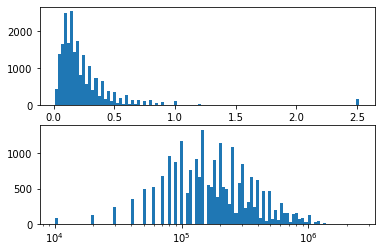

In [60]:
#Plot log histogram on linear scale
Value = clean_mergedf['VALUE_y']
plt.subplot(211)
hist, bins,_ = plt.hist(Value, bins=100)

#Plot histogram on log scale
#This histogram resembles closer to a Bell curve
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(Value, bins=logbins)
plt.xscale('log')
plt.show()

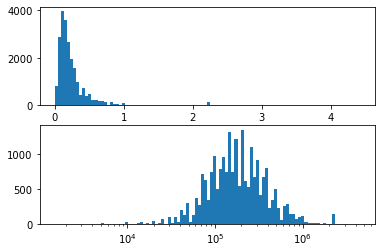

In [61]:
#Plot log histogram on linear scale
Value = clean_mergedf['VALUE_x']
plt.subplot(211)
hist, bins,_ = plt.hist(Value, bins=100)

#Plot histogram on log scale
#This histogram resembles closer to a Bell curve
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(Value, bins=logbins)
plt.xscale('log')
plt.show()

### Preparation of selecting X variables

In [36]:
clean_mergedf['METRO3_y'].value_counts()

'2'    8101
'1'    4806
'3'    3767
'5'    3627
'4'    1758
Name: METRO3_y, dtype: int64

In [37]:
new_metro3 = {"METRO3_y": {"'1'": "Central_City_Area","'2'": "Not_a_Central_city_area", "'3'": "Not_a_Central_city_area", "'4'":"Not_a_Central_city_area", "'5'": "Not_a_Central_city_area"},
               "METRO3_x": {"'1'": "Central_City_Area","'2'": "Not_a_Central_city_area", "'3'": "Not_a_Central_city_area", "'4'":"Not_a_Central_city_area", "'5'": "Not_a_Central_city_area"}}
clean_data1= clean_mergedf.replace(new_metro3)
clean_data1.head()
clean_data1["METRO3_y"].value_counts()

Not_a_Central_city_area    17253
Central_City_Area           4806
Name: METRO3_y, dtype: int64

In [ ]:
clean_data1["METRO3_x"].value_counts()

#Selected variables based on correlation heatmap

In [39]:
sel_col=[ 'CONTROL','AGE1_y', 'METRO3_y', 'LMED_y',
       'FMR_y', 'L30_y', 'L50_y', 'L80_y', 'IPOV_y', 'BEDRMS_y', 'BUILT_y',
       'TYPE_y', 'VALUE_y', 'VACANCY_y', 'TENURE_y', 'NUNITS_y', 'ROOMS_y',
       'WEIGHT_y', 'PER_y', 'ZINC2_y', 'ZADEQ_y', 'ZSMHC_y', 'STRUCTURETYPE_y',
       'OWNRENT_y', 'UTILITY_y', 'OTHERCOST_y', 'COST06_y', 'COST12_y',
       'COST08_y', 'COSTMED_y', 'TOTSAL_y', 'INCRELAMIPCT_y', 'INCRELPOVPCT_y',
       'INCRELFMRPCT_y', 'APLMED_y', 'ABL30_y', 'ABL50_y', 'ABL80_y',
       'ABLMED_y', 'BURDEN_y', 'GLMED_y']
clean_data4=clean_data1[sel_col].set_index('CONTROL')

<AxesSubplot:>

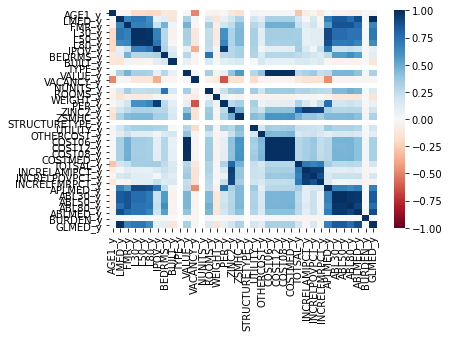

In [40]:
#Calculating pairwise correlation and using heatmap to present it.
corr = clean_data4.corr()
# Change the colormap to a divergent scale and fix the range of the colormap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap='RdBu')


<AxesSubplot:>

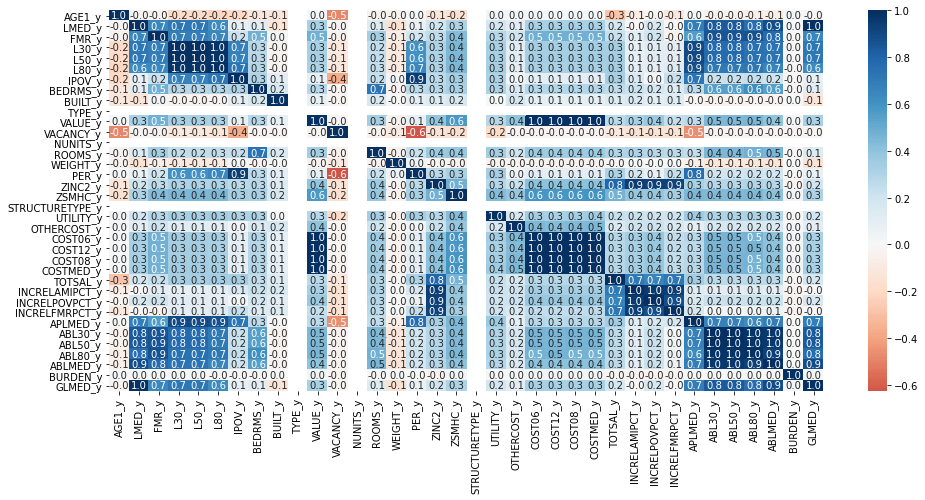

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap='RdBu', center=0, ax=ax)
#fig.savefig("fig_heat2.pdf")

In [43]:
#2011 data
sel_col = ['CONTROL','METRO3_x','FMR_x','BEDRMS_x','BUILT_x',
           'ROOMS_x','PER_x','ZINC2_x',
           'ZSMHC_x','UTILITY_x','OTHERCOST_x',"BURDEN_x",
              'GLMED_x','VALUE_x']
clean_data2 = clean_data1[sel_col].set_index('CONTROL')

<AxesSubplot:>

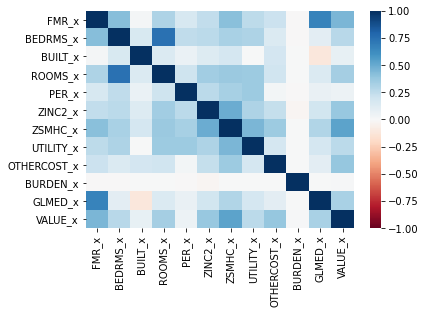

In [44]:
#Calculating pairwise correlation and using heatmap to present it
corr = clean_data2.corr()
# Change the colormap to a divergent scale and fix the range of the colormap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap='RdBu')

<AxesSubplot:>

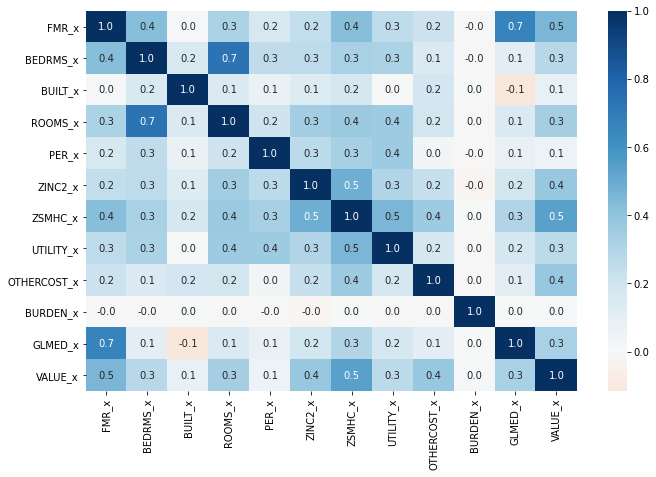

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap='RdBu', center=0, ax=ax)
#fig.savefig("fig_heat.pdf")

In [49]:
#2013 data
sel_col = ['CONTROL','METRO3_y','FMR_y','BEDRMS_y','BUILT_y',
           'ROOMS_y','PER_y','ZINC2_y',
           'ZSMHC_y','UTILITY_y','OTHERCOST_y',"BURDEN_y",
              'GLMED_y','VALUE_y']
clean_data3 = clean_data1[sel_col].set_index('CONTROL')

<AxesSubplot:>

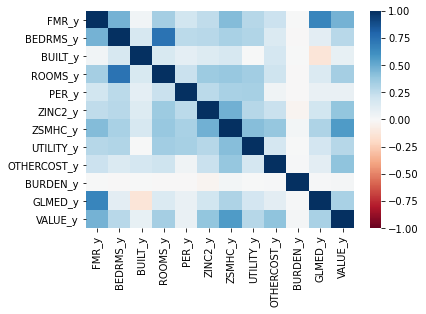

In [50]:
#Calculating pairwise correlation and using heatmap to present it.
corr = clean_data3.corr()
# Change the colormap to a divergent scale and fix the range of the colormap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap='RdBu')


<AxesSubplot:>

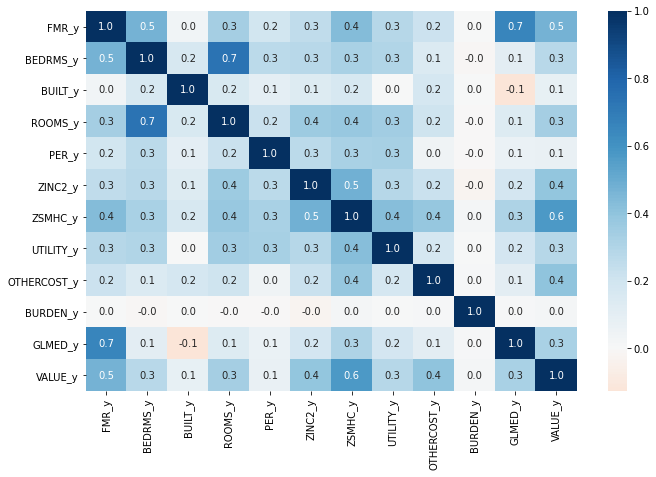

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap='RdBu', center=0, ax=ax)
#fig.savefig("fig_heat.pdf")

In [62]:
# Choose variables for regression model
sel_cols= ['CONTROL','METRO3_x','FMR_x','BEDRMS_x','BUILT_x',
           'ROOMS_x','PER_x','ZINC2_x',
           'ZSMHC_x','UTILITY_x','OTHERCOST_x',"BURDEN_x",
              'GLMED_x','VALUE_x','METRO3_y','FMR_y','BEDRMS_y','BUILT_y',
           'ROOMS_y','PER_y','ZINC2_y',
           'ZSMHC_y','UTILITY_y','OTHERCOST_y',"BURDEN_y",
              'GLMED_y','VALUE_y']
clean_data5 = clean_data1[sel_cols].set_index('CONTROL')

In [63]:
clean_data6 = pd.get_dummies(clean_data5, drop_first=True)

In [64]:
#normalise values of x variables
house_std = pd.DataFrame(zscore(clean_data6),columns=clean_data6.columns)

## Task 1

In [65]:
#Run Regression model with "BURDEN"
formula = "VALUE_y ~ FMR_y+BEDRMS_y+BUILT_y+ROOMS_y+PER_y+ZINC2_y+ZSMHC_y+UTILITY_y+OTHERCOST_y+BURDEN_y+GLMED_y+METRO3_y_Not_a_Central_city_area"
house_result = smf.ols(formula, house_std).fit()
house_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                VALUE_y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     1568.
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        12:13:21   Log-Likelihood:                -24493.
No. Observations:               22059   AIC:                         4.901e+04
Df Residuals:                   22046   BIC:                         4.912e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         5.204e-18      0.005   1.05e-15      1.000      -0.010       0.010
FMR_y                                0.3037      0.008     37.448      0.000       0.288       0.320
BEDRMS_y                            -0.0959      0.008    -11.564      0.000      -0.112      -0.080
BUILT_y                             -0.0340      0.005     -6.436      0.000      -0.044      -0.024
ROOMS_y                              0.1261      0.008     16.280      0.000       0.111       0.141
PER_y                               -0.1427      0.006    -25.867      0.000      -0.153      -0.132
ZINC2_y                              0.1379      0.006     23.500      0.000       0.126       0.149
ZSMHC_y                              0.3411      0.007     50.359      0.000       0.328       0.354
UTILITY_y                            0.0267      0.006      4.595      0.000       0.015       0.038
OTHERCOST_y                          0.1700      0.005     31.021      0.000       0.159       0.181
BURDEN_y                             0.0128      0.005      2.589      0.010       0.003       0.023
GLMED_y                             -0.0339      0.007     -4.763      0.000      -0.048      -0.020
METRO3_y_Not_a_Central_city_area     0.0296      0.005      5.881      0.000       0.020       0.039
==============================================================================
Omnibus:                    22340.374   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1809287.574
Skew:                           4.933   Prob(JB):                         0.00
Kurtosis:                      46.257   Cond. No.                         4.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
#Run Regression model without "BURDEN"
formula = "VALUE_y ~ FMR_y+BEDRMS_y+BUILT_y+ROOMS_y+PER_y+ZINC2_y+ZSMHC_y+UTILITY_y+OTHERCOST_y+GLMED_y+METRO3_y_Not_a_Central_city_area"
house_result = smf.ols(formula, house_std).fit()
house_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                VALUE_y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     1710.
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        12:15:51   Log-Likelihood:                -24496.
No. Observations:               22059   AIC:                         4.902e+04
Df Residuals:                   22047   BIC:                         4.911e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         5.204e-18      0.005   1.05e-15      1.000      -0.010       0.010
FMR_y                                0.3036      0.008     37.432      0.000       0.288       0.320
BEDRMS_y                            -0.0960      0.008    -11.581      0.000      -0.112      -0.080
BUILT_y                             -0.0339      0.005     -6.422      0.000      -0.044      -0.024
ROOMS_y                              0.1262      0.008     16.286      0.000       0.111       0.141
PER_y                               -0.1427      0.006    -25.862      0.000      -0.153      -0.132
ZINC2_y                              0.1373      0.006     23.411      0.000       0.126       0.149
ZSMHC_y                              0.3418      0.007     50.475      0.000       0.328       0.355
UTILITY_y                            0.0266      0.006      4.580      0.000       0.015       0.038
OTHERCOST_y                          0.1701      0.005     31.036      0.000       0.159       0.181
GLMED_y                             -0.0337      0.007     -4.737      0.000      -0.048      -0.020
METRO3_y_Not_a_Central_city_area     0.0297      0.005      5.893      0.000       0.020       0.040
==============================================================================
Omnibus:                    22340.315   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1808171.589
Skew:                           4.934   Prob(JB):                         0.00
Kurtosis:                      46.243   Cond. No.                         4.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
sm.stats.anova_lm(house_result)

,df,sum_sq,mean_sq,F,PR(>F)
FMR_y,1.0,4963.281399,4963.281399,9192.831117,0.000000e+00
BEDRMS_y,1.0,75.356998,75.356998,139.573822,4.123908e-32
BUILT_y,1.0,70.420514,70.420514,130.430625,4.009201e-30
ROOMS_y,1.0,919.194004,919.194004,1702.501744,0.000000e+00
PER_y,1.0,33.316829,33.316829,61.708365,4.164031e-15
ZINC2_y,1.0,1302.278934,1302.278934,2412.039405,0.000000e+00
ZSMHC_y,1.0,2218.580898,2218.580898,4109.184606,0.000000e+00
UTILITY_y,1.0,13.818951,13.818951,25.595020,4.245049e-07
OTHERCOST_y,1.0,530.368990,530.368990,982.332486,5.243316e-211
GLMED_y,1.0,10.283592,10.283592,19.046941,1.281218e-05


In [69]:
#Heteroskedasticity Tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(house_result.resid, house_result.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 2013.6835702165204,
 'p-value': 0.0,
 'f-value': 201.3423472400502,
 'f p-value': 0.0}

In [81]:
#Calculating VIF
x_variables = ['FMR_y', 'BEDRMS_y', 'BUILT_y', 'ROOMS_y',
       'PER_y', 'ZINC2_y', 'ZSMHC_y', 'UTILITY_y', 'OTHERCOST_y',
      'GLMED_y','METRO3_y_Not_a_Central_city_area']

In [82]:
for idx, var in enumerate(x_variables):
    print(var, ":", outliers_influence.variance_inflation_factor(house_result.model.exog,idx))

FMR_y : 0.9999999999999993
BEDRMS_y : 2.68829847300986
BUILT_y : 2.8105424204110814
ROOMS_y : 1.1375709845354076
PER_y : 2.4520033786997293
ZINC2_y : 1.2433389824870797
ZSMHC_y : 1.4046495333359754
UTILITY_y : 1.8730774742038843
OTHERCOST_y : 1.374765288191164
GLMED_y : 1.227727588969214
METRO3_y_Not_a_Central_city_area : 2.072250788191865


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

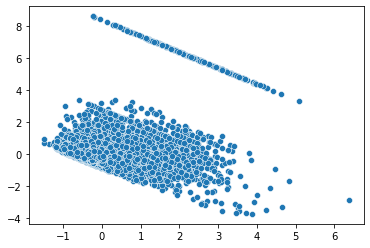

In [125]:
#residual-versus-fitted plot
#residual distribution
sns.scatterplot(house_result.fittedvalues, house_result.resid)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

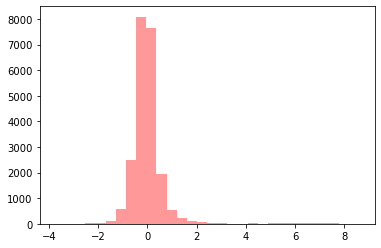

In [73]:
#residual distribution
data2 = house_result.resid
sns.distplot(data2, kde=False, color='red', bins=30)

In [74]:
house_result.model.exog

array([[ 1.        , -0.72486763, -1.50039848, ...,  1.18262828,
         0.64906603,  0.52778807],
       [ 1.        , -0.35999746,  0.89691356, ..., -0.34651719,
        -0.85839431,  0.52778807],
       [ 1.        , -0.74260437, -0.30174246, ..., -0.22516945,
        -0.85839431,  0.52778807],
       ...,
       [ 1.        ,  0.35200614,  0.89691356, ..., -0.39161263,
        -0.26407142, -1.89469988],
       [ 1.        , -0.28651666, -0.30174246, ..., -0.33011885,
        -0.26407142, -1.89469988],
       [ 1.        , -1.52302112, -2.6990545 , ..., -0.26616531,
        -0.39643338,  0.52778807]])

In [75]:
# Condition number for collinearity
np.linalg.cond(house_result.model.exog[:,1:])

4.411179193156151

In [76]:
#Robust Regression 
house_result_robust = smf.rlm(formula, house_std).fit()
house_result_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                VALUE_y   No. Observations:                22059
Model:                            RLM   Df Residuals:                    22047
Method:                          IRLS   Df Model:                           11
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 11 May 2021                                         
Time:                        12:19:39                                         
No. Iterations:                    35                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.1013      0.002    -44.010      0.000      -0.106      -0.097
FMR_y                                0.2126      0.004     56.328      0.000       0.205       0.220
BEDRMS_y                            -0.0744      0.004    -19.270      0.000      -0.082      -0.067
BUILT_y                              0.0141      0.002      5.744      0.000       0.009       0.019
ROOMS_y                              0.1047      0.004     29.045      0.000       0.098       0.112
PER_y                               -0.0746      0.003    -29.069      0.000      -0.080      -0.070
ZINC2_y                              0.1058      0.003     38.757      0.000       0.100       0.111
ZSMHC_y                              0.2506      0.003     79.527      0.000       0.244       0.257
UTILITY_y                           -0.0078      0.003     -2.887      0.004      -0.013      -0.003
OTHERCOST_y                          0.1042      0.003     40.836      0.000       0.099       0.109
GLMED_y                              0.0104      0.003      3.128      0.002       0.004       0.017
METRO3_y_Not_a_Central_city_area     0.0243      0.002     10.382      0.000       0.020       0.029
====================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

#### Prediction

In [77]:
#partition data for house_result
predictors = ['FMR_y', 'BEDRMS_y', 'BUILT_y', 'ROOMS_y',
       'PER_y', 'ZINC2_y', 'ZSMHC_y', 'UTILITY_y', 'OTHERCOST_y', 'BURDEN_y',
      'GLMED_y','METRO3_y_Not_a_Central_city_area']
outcome = 'VALUE_y'
X = house_std[predictors]
y = house_std[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 1000, random_state=1)

In [78]:
#Backward Elimination
def train_model (variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model
def score_model (model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)
allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, 
                                                  train_model, 
                                                  score_model, 
                                                  verbose=True)
print(best_variables)

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Variables: FMR_y, BEDRMS_y, BUILT_y, ROOMS_y, PER_y, ZINC2_y, ZSMHC_y, UTILITY_y, OTHERCOST_y, BURDEN_y, GLMED_y, METRO3_y_Not_a_Central_city_area
Start: score=46652.02
Step: score=46650.03, remove BURDEN_y
Step: score=46650.03, remove None
['FMR_y', 'BEDRMS_y', 'BUILT_y', 'ROOMS_y', 'PER_y', 'ZINC2_y', 'ZSMHC_y', 'UTILITY_y', 'OTHERCOST_y', 'GLMED_y', 'METRO3_y_Not_a_Central_city_area']

Regression statistics

                      Mean Error (ME) : 0.0176
       Root Mean Squared Error (RMSE) : 0.7874
            Mean Absolute Error (MAE) : 0.3981
          Mean Percentage Error (MPE) : 0.8268
Mean Absolute Percentage Error (MAPE) : 983.0293


In [114]:
#partition data for house_result
predictors = ['FMR_y', 'BEDRMS_y', 'BUILT_y', 'ROOMS_y',
       'PER_y', 'ZINC2_y', 'ZSMHC_y', 'UTILITY_y', 'OTHERCOST_y',
      'GLMED_y','METRO3_y_Not_a_Central_city_area']
outcome = 'VALUE_y'
X = house_std[predictors]
y = house_std[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 1000, random_state=1)

In [115]:
#Backward Elimination
def train_model (variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model
def score_model (model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)
allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, 
                                                  train_model, 
                                                  score_model, 
                                                  verbose=True)
print(best_variables)

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Variables: FMR_y, BEDRMS_y, BUILT_y, ROOMS_y, PER_y, ZINC2_y, ZSMHC_y, UTILITY_y, OTHERCOST_y, GLMED_y, METRO3_y_Not_a_Central_city_area
Start: score=46650.03
Step: score=46650.03, remove None
['FMR_y', 'BEDRMS_y', 'BUILT_y', 'ROOMS_y', 'PER_y', 'ZINC2_y', 'ZSMHC_y', 'UTILITY_y', 'OTHERCOST_y', 'GLMED_y', 'METRO3_y_Not_a_Central_city_area']

Regression statistics

                      Mean Error (ME) : 0.0176
       Root Mean Squared Error (RMSE) : 0.7874
            Mean Absolute Error (MAE) : 0.3981
          Mean Percentage Error (MPE) : 0.8268
Mean Absolute Percentage Error (MAPE) : 983.0293


In [116]:
house2013_lm = LinearRegression()
house2013_lm.fit(train_X, train_y)

LinearRegression()

In [117]:
print(pd.DataFrame({'Predictors': X.columns, "Coefficients": house2013_lm.coef_}))

                          Predictors  Coefficients
0                              FMR_y      0.301727
1                           BEDRMS_y     -0.096725
2                            BUILT_y     -0.032924
3                            ROOMS_y      0.130203
4                              PER_y     -0.142640
5                            ZINC2_y      0.137700
6                            ZSMHC_y      0.342288
7                          UTILITY_y      0.026453
8                        OTHERCOST_y      0.164094
9                            GLMED_y     -0.034639
10  METRO3_y_Not_a_Central_city_area      0.028172


In [118]:
#print performance measures (training data)
regressionSummary(train_y, house2013_lm.predict(train_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.7320
            Mean Absolute Error (MAE) : 0.3893
          Mean Percentage Error (MPE) : -92.5878
Mean Absolute Percentage Error (MAPE) : 714.5087


In [119]:
# Use predict () to make predictions on a new set
house2013_lm_pred=house2013_lm.predict(valid_X)
result = pd.DataFrame({'Predicted': house2013_lm_pred, 'Actual': valid_y, 
                       'Residual': valid_y - house2013_lm_pred})
print(result.head(20))

# print performance measures (validation data)
regressionSummary(valid_y, house2013_lm_pred)

       Predicted    Actual  Residual
4771   -0.526811 -0.402941  0.123870
21206  -0.530840  0.002271  0.533111
13     -0.973115 -0.771316  0.201799
4230   -0.006624  1.475770  1.482394
4423   -0.335602 -0.034566  0.301035
2904   -0.815393 -0.808153  0.007240
7768    0.008029  1.844145  1.836116
4784   -0.507687 -0.513454 -0.005767
8620   -0.318490 -0.476616 -0.158126
15153  -0.010289  0.333808  0.344098
18516  -0.815289 -0.292429  0.522861
13906  -0.825276 -0.771316  0.053960
3674    0.064608 -0.476616 -0.541224
11971  -0.200626 -0.255591 -0.054965
15034  -0.829830 -0.255591  0.574239
7700   -0.577458 -0.697641 -0.120183
17508  -0.640352 -0.734478 -0.094126
20160   2.059068  0.628508 -1.430560
10829   0.000797 -0.402941 -0.403738
9110   -0.497215 -0.329266  0.167949

Regression statistics

                      Mean Error (ME) : 0.0176
       Root Mean Squared Error (RMSE) : 0.7874
            Mean Absolute Error (MAE) : 0.3981
          Mean Percentage Error (MPE) : 0.8268
Mean Absolu

In [120]:
house2013_lm_pred = house2013_lm.predict(valid_X)
all_residuals = valid_y - house2013_lm_pred
all_residuals.describe()

count    1000.000000
mean        0.017604
std         0.787592
min        -2.988032
25%        -0.307125
50%        -0.065403
75%         0.176597
max         7.556841
Name: VALUE_y, dtype: float64

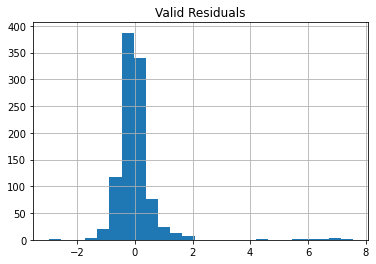

In [121]:
all_residuals = all_residuals[all_residuals<30000]
pd.DataFrame ({'Valid Residuals': all_residuals}).hist(bins=25)
plt.show()

array([[<AxesSubplot:title={'center':'Train Residuals'}>]], dtype=object)

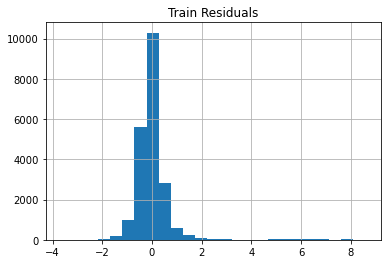

In [122]:
train_residuals = train_y - house2013_lm.predict(train_X)
pd.DataFrame({'Train Residuals': train_residuals}).hist(bins=25)


In [123]:
xvar = sm.add_constant (train_X)
results = sm.OLS(train_y, xvar).fit()

In [124]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                VALUE_y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     1629.
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        13:24:08   Log-Likelihood:                -23312.
No. Observations:               21059   AIC:                         4.665e+04
Df Residuals:                   21047   BIC:                         4.674e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.0008      0.005     -0.158      0.874      -0.011       0.009
FMR_y                                0.3017      0.008     36.568      0.000       0.286       0.318
BEDRMS_y                            -0.0967      0.008    -11.416      0.000      -0.113      -0.080
BUILT_y                             -0.0329      0.005     -6.106      0.000      -0.043      -0.022
ROOMS_y                              0.1302      0.008     16.444      0.000       0.115       0.146
PER_y                               -0.1426      0.006    -25.430      0.000      -0.154      -0.132
ZINC2_y                              0.1377      0.006     23.036      0.000       0.126       0.149
ZSMHC_y                              0.3423      0.007     49.609      0.000       0.329       0.356
UTILITY_y                            0.0265      0.006      4.482      0.000       0.015       0.038
OTHERCOST_y                          0.1641      0.006     29.398      0.000       0.153       0.175
GLMED_y                             -0.0346      0.007     -4.775      0.000      -0.049      -0.020
METRO3_y_Not_a_Central_city_area     0.0282      0.005      5.495      0.000       0.018       0.038
==============================================================================
Omnibus:                    21370.844   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1744697.928
Skew:                           4.947   Prob(JB):                         0.00
Kurtosis:                      46.480   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Task 2

In [130]:
#partition data for house_result
predictors = ['FMR_x', 'BEDRMS_x', 'BUILT_x', 'ROOMS_x', 'PER_x', 'ZINC2_x',
       'ZSMHC_x', 'UTILITY_x', 'OTHERCOST_x', 'BURDEN_x', 'GLMED_x', 'METRO3_x_Not_a_Central_city_area']
outcome = 'VALUE_y'
X = house_std[predictors]
y = house_std[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 1000, random_state=1)

In [131]:
#Backward Elimination
def train_model (variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model
def score_model (model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)
allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, 
                                                  train_model, 
                                                  score_model, 
                                                  verbose=True)
print(best_variables)

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Variables: FMR_x, BEDRMS_x, BUILT_x, ROOMS_x, PER_x, ZINC2_x, ZSMHC_x, UTILITY_x, OTHERCOST_x, BURDEN_x, GLMED_x, METRO3_x_Not_a_Central_city_area
Start: score=49714.07
Step: score=49714.02, remove BUILT_x
Step: score=49714.02, remove None
['FMR_x', 'BEDRMS_x', 'ROOMS_x', 'PER_x', 'ZINC2_x', 'ZSMHC_x', 'UTILITY_x', 'OTHERCOST_x', 'BURDEN_x', 'GLMED_x', 'METRO3_x_Not_a_Central_city_area']

Regression statistics

                      Mean Error (ME) : 0.0240
       Root Mean Squared Error (RMSE) : 0.8495
            Mean Absolute Error (MAE) : 0.4235
          Mean Percentage Error (MPE) : -11.7620
Mean Absolute Percentage Error (MAPE) : 903.5394


In [152]:
#partition data for house_result
predictors = ['FMR_x', 'BEDRMS_x', 'ROOMS_x', 'PER_x', 'ZINC2_x',
       'ZSMHC_x', 'UTILITY_x', 'OTHERCOST_x', 'BURDEN_x', 'GLMED_x', 'METRO3_x_Not_a_Central_city_area']
outcome = 'VALUE_y'
X = house_std[predictors]
y = house_std[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 1000, random_state=1)

In [153]:
#Backward Elimination
def train_model (variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model
def score_model (model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)
allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, 
                                                  train_model, 
                                                  score_model, 
                                                  verbose=True)
print(best_variables)

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Variables: FMR_x, BEDRMS_x, ROOMS_x, PER_x, ZINC2_x, ZSMHC_x, UTILITY_x, OTHERCOST_x, BURDEN_x, GLMED_x, METRO3_x_Not_a_Central_city_area
Start: score=49714.02
Step: score=49714.02, remove None
['FMR_x', 'BEDRMS_x', 'ROOMS_x', 'PER_x', 'ZINC2_x', 'ZSMHC_x', 'UTILITY_x', 'OTHERCOST_x', 'BURDEN_x', 'GLMED_x', 'METRO3_x_Not_a_Central_city_area']

Regression statistics

                      Mean Error (ME) : 0.0240
       Root Mean Squared Error (RMSE) : 0.8495
            Mean Absolute Error (MAE) : 0.4235
          Mean Percentage Error (MPE) : -11.7620
Mean Absolute Percentage Error (MAPE) : 903.5394


In [163]:
#Run Regression model without "BUILT"
formula = "VALUE_y ~ FMR_x+BEDRMS_x+ROOMS_x+PER_x+ZINC2_x+ZSMHC_x+UTILITY_x+OTHERCOST_x+BURDEN_x+GLMED_x+METRO3_x_Not_a_Central_city_area"
house_result = smf.ols(formula, house_std).fit()
house_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                VALUE_y   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     1206.
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        14:23:16   Log-Likelihood:                -26105.
No. Observations:               22059   AIC:                         5.223e+04
Df Residuals:                   22047   BIC:                         5.233e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         5.204e-18      0.005   9.78e-16      1.000      -0.010       0.010
FMR_x                                0.3284      0.009     38.428      0.000       0.312       0.345
BEDRMS_x                            -0.0849      0.009     -9.603      0.000      -0.102      -0.068
ROOMS_x                              0.1461      0.008     17.303      0.000       0.130       0.163
PER_x                               -0.1282      0.006    -21.489      0.000      -0.140      -0.117
ZINC2_x                              0.1426      0.006     22.543      0.000       0.130       0.155
ZSMHC_x                              0.2321      0.007     31.870      0.000       0.218       0.246
UTILITY_x                            0.0325      0.006      5.116      0.000       0.020       0.045
OTHERCOST_x                          0.1190      0.006     20.406      0.000       0.108       0.130
BURDEN_x                             0.0161      0.005      3.033      0.002       0.006       0.027
GLMED_x                             -0.0180      0.008     -2.370      0.018      -0.033      -0.003
METRO3_x_Not_a_Central_city_area     0.0245      0.005      4.569      0.000       0.014       0.035
==============================================================================
Omnibus:                    23218.586   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1975164.026
Skew:                           5.262   Prob(JB):                         0.00
Kurtosis:                      48.147   Cond. No.                         4.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
#Calculating VIF
x_variables = ['FMR_x', 'BEDRMS_x', 'ROOMS_x', 'PER_x', 'ZINC2_x', 'ZSMHC_x', 'UTILITY_x', 'OTHERCOST_x', 'BURDEN_x', 'GLMED_x', 'METRO3_x_Not_a_Central_city_area']

In [165]:
for idx, var in enumerate(x_variables):
    print(var, ":", outliers_influence.variance_inflation_factor(house_result.model.exog,idx))

FMR_x : 1.0
BEDRMS_x : 2.578541096738216
ROOMS_x : 2.757844947834486
PER_x : 2.517655202983138
ZINC2_x : 1.2577345512539089
ZSMHC_x : 1.4135136271627515
UTILITY_x : 1.8728807920950716
OTHERCOST_x : 1.4225117235434617
BURDEN_x : 1.2002583604463501
GLMED_x : 1.0007561381675216
METRO3_x_Not_a_Central_city_area : 2.0353636234287054


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

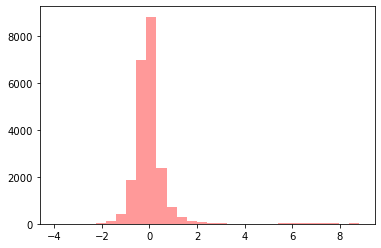

In [166]:
#residual distribution
data2 = house_result.resid
sns.distplot(data2, kde=False, color='red', bins=30)

In [154]:
house2011_lm = LinearRegression()
house2011_lm.fit(train_X, train_y)

LinearRegression()

In [155]:
print(pd.DataFrame({'Predictors': X.columns, "Coefficients": house2011_lm.coef_}))

                          Predictors  Coefficients
0                              FMR_x      0.322784
1                           BEDRMS_x     -0.084477
2                            ROOMS_x      0.148518
3                              PER_x     -0.128047
4                            ZINC2_x      0.140669
5                            ZSMHC_x      0.232136
6                          UTILITY_x      0.031972
7                        OTHERCOST_x      0.119323
8                           BURDEN_x      0.016083
9                            GLMED_x     -0.015020
10  METRO3_x_Not_a_Central_city_area      0.022590


In [156]:
#print performance measures (training data)
regressionSummary(train_y, house2011_lm.predict(train_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.7873
            Mean Absolute Error (MAE) : 0.4074
          Mean Percentage Error (MPE) : -52.6383
Mean Absolute Percentage Error (MAPE) : 674.5133


In [157]:
# Use predict () to make predictions on a new set
house2011_lm_pred=house2011_lm.predict(valid_X)
result = pd.DataFrame({'Predicted': house2011_lm_pred, 'Actual': valid_y, 
                       'Residual': valid_y - house2011_lm_pred})
print(result.head(20))

# print performance measures (validation data)
regressionSummary(valid_y, house2011_lm_pred)

       Predicted    Actual  Residual
4771   -0.622586 -0.402941  0.219645
21206  -0.319298  0.002271  0.321569
13     -0.533106 -0.771316 -0.238210
4230    0.147185  1.475770  1.328585
4423   -0.228423 -0.034566  0.193856
2904   -0.524935 -0.808153 -0.283218
7768    0.013230  1.844145  1.830915
4784   -0.496731 -0.513454 -0.016722
8620   -0.060556 -0.476616 -0.416060
15153   0.069585  0.333808  0.264223
18516  -0.646746 -0.292429  0.354318
13906  -0.837312 -0.771316  0.065996
3674    0.137123 -0.476616 -0.613739
11971   0.045896 -0.255591 -0.301487
15034   0.899728 -0.255591 -1.155319
7700   -0.437769 -0.697641 -0.259872
17508  -0.744797 -0.734478  0.010319
20160   1.644556  0.628508 -1.016047
10829   0.023845 -0.402941 -0.426786
9110   -0.476741 -0.329266  0.147475

Regression statistics

                      Mean Error (ME) : 0.0240
       Root Mean Squared Error (RMSE) : 0.8495
            Mean Absolute Error (MAE) : 0.4235
          Mean Percentage Error (MPE) : -11.7620
Mean Abso

In [158]:
house2011_lm_pred = house2011_lm.predict(valid_X)
all_residuals = valid_y - house2011_lm_pred
all_residuals.describe()

count    1000.000000
mean        0.024042
std         0.849601
min        -2.109360
25%        -0.323037
50%        -0.067740
75%         0.183803
max         7.597137
Name: VALUE_y, dtype: float64

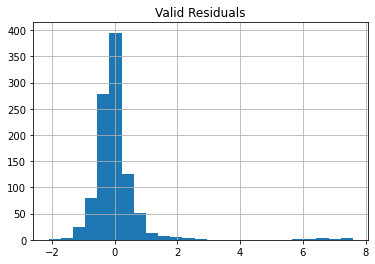

In [159]:
all_residuals = all_residuals[all_residuals<1000]
pd.DataFrame ({'Valid Residuals': all_residuals}).hist(bins=25)
plt.show()

array([[<AxesSubplot:title={'center':'Train Residuals'}>]], dtype=object)

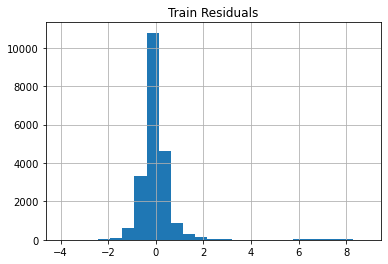

In [160]:
train_residuals = train_y - house2011_lm.predict(train_X)
pd.DataFrame({'Train Residuals': train_residuals}).hist(bins=25)


In [161]:
xvar = sm.add_constant (train_X)
results = sm.OLS(train_y, xvar).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                VALUE_y   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     1149.
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        14:16:44   Log-Likelihood:                -24844.
No. Observations:               21059   AIC:                         4.971e+04
Df Residuals:                   21047   BIC:                         4.981e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.0011      0.005     -0.201      0.841      -0.012       0.010
FMR_x                                0.3228      0.009     37.148      0.000       0.306       0.340
BEDRMS_x                            -0.0845      0.009     -9.361      0.000      -0.102      -0.067
ROOMS_x                              0.1485      0.009     17.222      0.000       0.132       0.165
PER_x                               -0.1280      0.006    -21.160      0.000      -0.140      -0.116
ZINC2_x                              0.1407      0.006     21.840      0.000       0.128       0.153
ZSMHC_x                              0.2321      0.007     31.196      0.000       0.218       0.247
UTILITY_x                            0.0320      0.006      4.936      0.000       0.019       0.045
OTHERCOST_x                          0.1193      0.006     20.006      0.000       0.108       0.131
BURDEN_x                             0.0161      0.005      3.032      0.002       0.006       0.026
GLMED_x                             -0.0150      0.008     -1.943      0.052      -0.030       0.000
METRO3_x_Not_a_Central_city_area     0.0226      0.005      4.138      0.000       0.012       0.033
==============================================================================
Omnibus:                    22199.633   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1913227.609
Skew:                           5.269   Prob(JB):                         0.00
Kurtosis:                      48.490   Cond. No.                         4.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""